## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

In [9]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/"
position_count_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/"
te_table_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/'
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/"
save_path2 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/initiation_rates/dmel/"
save_path3 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/termination_rates/dmel/"
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/dmel/'
gtf_name = "Drosophila_melanogaster.BDGP6.32.103.gtf"
mutation = 'Fmr1'
samp_num = '3'

## Loading up the data files 

In [6]:
init_mutant = np.loadtxt(save_path2 + mutation + '_' + samp_num + 'adjusted_initiation_rates', delimiter = ",")

In [7]:
term_mutant = np.loadtxt(save_path3 + mutation + '_' + samp_num + 'adjusted_termination_rates', delimiter = ",")

In [29]:
def load_elongation_rates_v2(csv_name, csv_path):
    data = []
    gene_names = []
    tr_ids = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = float(j)
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        data[ii] = np.array(data[ii][2:]) # I think that this is my target, I just need it to also capture
        gene_names.append(data[ii][1])
        tr_ids.append(data[ii][0])
        
    
    return data, gene_names, tr_ids

In [17]:
data = []
gene_names = []
tr_ids = []
with open(elon_path + mutation + '_' + samp_num + '_elongation_rates', newline = '') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append(row)
blank=data.pop(0)

In [25]:
for i,ii in zip(data, range(len(data))):
    x = list(filter(('').__ne__, i))
    data[ii] = x

In [26]:
data[100][1]

'spen'

In [30]:
# Load in the elongation rates data.
elon_mutant, gene_names, tr_ids = load_elongation_rates_v2(mutation + '_' + samp_num + '_elongation_rates', elon_path)
#elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

In [33]:
# Load in the count positions data.
counts_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",position_count_path)
counts_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",position_count_path)

## Define functions

In [38]:
def get_density(lamb, a, B, I = 10, intermediates = False):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        density = "LD"
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        density = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            density = "LD"
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            density = "HD"
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        density = "MC"
    if intermediates == False:
        return p, density
    elif intermediates == True:
        return p, a, B, crit_a, crit_B, min(lamb_c), lamb_c[0]
    
def get_critical_values(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    return(crit_a, crit_B)

## Clean data

In [71]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
clean_elons = []
clean_inits = []
clean_terms = []
clean_gene_names = []
clean_tr_ids = []
for tr_m, tr_c, el_m, in_m, term_m, gi, tr_id in zip(counts_mutant, counts_control, elon_mutant, init_mutant, term_mutant, gene_names, tr_ids):
    if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
        clean_elons.append(el_m)
        clean_inits.append(in_m)
        clean_terms.append(term_m)
        clean_gene_names.append(gi)
        clean_tr_ids.append(tr_id)

In [72]:
crit_as = []
crit_Bs = []
for ce, ci, ct in zip(clean_elons, clean_inits, clean_terms):
    crit_a, crit_B = get_critical_values(ce, ci, ct)
    crit_as.append(crit_a)
    crit_Bs.append(crit_B)

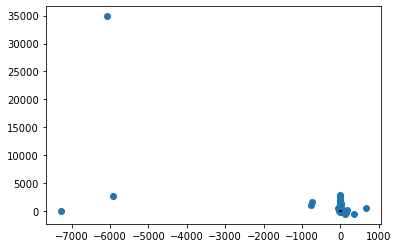

In [76]:
plt.scatter((np.array(clean_inits)/np.array(crit_as)), ((np.array(clean_terms))/np.array(crit_Bs)))
#plt.ylim([0,90])
#plt.xlim([0,9])
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

## Look at just the Fmr1 targets